### Sample code for Introduction to Neural Networks in Python: Part 2
- Topics covered
    - Regularization (weight penalities (l2, l1), dropout, early stopping)
    - Convolutional networks
    - Other techniques for improving the weight networks learn (momentum / other optimizers, weight initialization, adversarial training, dataset augmentation)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.regularizers import l2, l1

Using Theano backend.


In [2]:
train_data = pickle.load(open("CIFAR_2_train_data.pkl", 'rb'))
train_labels = pickle.load(open("CIFAR_2_train_labels.pkl", 'rb'))
test_data = pickle.load(open("CIFAR_2_test_data.pkl", 'rb'))
test_labels = pickle.load(open("CIFAR_2_test_labels.pkl", 'rb'))
print("Training data shape: {}".format(train_data.shape))
print("Training labels shape: {}".format(train_labels.shape))
print("Test data shape: {}".format(test_data.shape))
print("Test labels shape: {}".format(test_labels.shape))
label_dict = ["airplane", "cat"]
label_dict[0]

Training data shape: (10000, 3, 32, 32)
Training labels shape: (10000, 2)
Test data shape: (2000, 3, 32, 32)
Test labels shape: (2000, 2)


'airplane'

In [3]:
def plotExamples(data, labels, label_dict):
    plt.figure(figsize=(8,5))
    for i in range(8):
        sub = 241 + i
        ax = plt.subplot(sub)
        index = np.random.randint(0, data.shape[0])
        label_int = np.argmax(labels[index])
        ax.set_title(label_dict[label_int])
        im = data[index]
        im = np.transpose(im, (1, 2, 0))
        plt.imshow(im)
    plt.show()

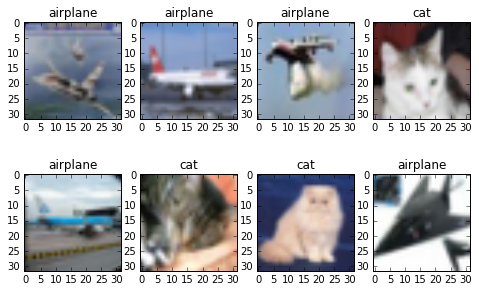

In [4]:
plotExamples(train_data, train_labels, label_dict)

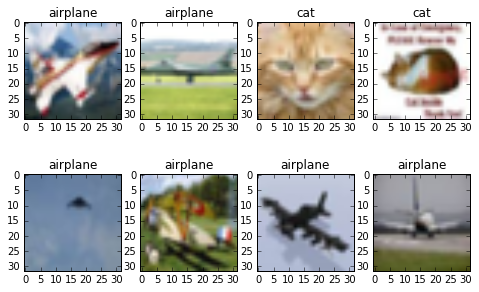

In [5]:
plotExamples(test_data, test_labels, label_dict)

## Feedforward networks

In [6]:
# Flatten data
def flatten(data):
    return np.reshape(data, (data.shape[0], data.shape[1] * data.shape[2] * data.shape[3]))

train_data_flat = flatten(train_data)
test_data_flat = flatten(test_data)
train_data_flat_short = train_data_flat[:5000]
train_labels_short = train_labels[:5000]
print("Train data: Orig shape: {} New shape {}".format(train_data.shape, train_data_flat.shape))
print("Test data: Orig shape: {} New shape {}".format(test_data.shape, test_data_flat.shape))
print("Short train data: Shape {}".format(train_data_flat_short.shape))
print("Short train labels: Shape {}".format(train_labels_short.shape))

Train data: Orig shape: (10000, 3, 32, 32) New shape (10000, 3072)
Test data: Orig shape: (2000, 3, 32, 32) New shape (2000, 3072)
Short train data: Shape (5000, 3072)
Short train labels: Shape (5000, 2)


### Two simple models to start with, no regularization

In [12]:
# Try running this a few times with and without additional hidden layer. What happens?
model = Sequential()
model.add(Dense(1024, input_dim=3072, activation='relu'))
model.add(Dense(512, activation='relu'))
#model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()
sgd = SGD(lr=0.00001)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data_flat_short, train_labels_short, batch_size=128, nb_epoch=20, validation_split=0.2, verbose=2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_21 (Dense)                 (None, 1024)          3146752     dense_input_6[0][0]              
____________________________________________________________________________________________________
dense_22 (Dense)                 (None, 512)           524800      dense_21[0][0]                   
____________________________________________________________________________________________________
dense_23 (Dense)                 (None, 2)             1026        dense_22[0][0]                   
Total params: 3672578
____________________________________________________________________________________________________
Train on 4000 samples, validate on 1000 samples
Epoch 1/20
1s - loss: 7.9509 - acc: 0.5020 - val_loss: 7.9462 - val_acc: 0.5070
Epoch 2/20
1s - loss: 7.9318 - acc: 0.5058

In [7]:
model = Sequential()
model.add(Dense(1024, input_dim=3072, activation='relu', init='lecun_uniform'))
model.add(Dense(512, activation='relu',  init='lecun_uniform'))
model.add(Dense(256, activation='relu',  init='lecun_uniform'))
model.add(Dense(2, activation='softmax',  init='lecun_uniform'))
model.summary()
sgd = SGD(lr=0.00001)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data_flat_short, train_labels_short, batch_size=128, nb_epoch=20, validation_split=0.2, verbose=2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 1024)          3146752     dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 512)           524800      dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 256)           131328      dense_2[0][0]                    
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 2)             514         dense_3[0][0]                    
Total params: 3803394
_____________________________________________________________________

### Adding more layers and making the network layers larger leads to improved performance on the training set, but overfitting is now an issue
- ~14ppts accuracy difference between training and validation dataset 

In [14]:
model = Sequential()
model.add(Dense(2048, input_dim=3072, activation='relu', init='lecun_uniform'))
model.add(Dense(1024, activation='relu',  init='lecun_uniform'))
model.add(Dense(512, activation='relu',  init='lecun_uniform'))
model.add(Dense(256, activation='relu',  init='lecun_uniform'))
model.add(Dense(128, activation='relu',  init='lecun_uniform'))
model.add(Dense(2, activation='softmax',  init='lecun_uniform'))
model.summary()
sgd = SGD(lr=0.00001, momentum=0.95, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data_flat_short, train_labels_short, batch_size=128, nb_epoch=20, validation_split=0.2, verbose=2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_30 (Dense)                 (None, 2048)          6293504     dense_input_8[0][0]              
____________________________________________________________________________________________________
dense_31 (Dense)                 (None, 1024)          2098176     dense_30[0][0]                   
____________________________________________________________________________________________________
dense_32 (Dense)                 (None, 512)           524800      dense_31[0][0]                   
____________________________________________________________________________________________________
dense_33 (Dense)                 (None, 256)           131328      dense_32[0][0]                   
___________________________________________________________________________________________

### Regularization examples
- L1, L2 weight penalties and dropout

#### L2 weight regularization
- What happens as you change the regularization parameter?

In [15]:
model = Sequential()
model.add(Dense(2048, input_dim=3072, activation='relu', init='lecun_uniform', W_regularizer=l2(0.01)))
model.add(Dense(1024, activation='relu',  init='lecun_uniform', W_regularizer=l2(0.01)))
model.add(Dense(512, activation='relu',  init='lecun_uniform', W_regularizer=l2(0.01)))
model.add(Dense(256, activation='relu',  init='lecun_uniform', W_regularizer=l2(0.01)))
model.add(Dense(128, activation='relu',  init='lecun_uniform', W_regularizer=l2(0.01)))
model.add(Dense(2, activation='softmax',  init='lecun_uniform', W_regularizer=l2(0.01)))
model.summary()
sgd = SGD(lr=0.00001, momentum=0.95, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data_flat_short, train_labels_short, batch_size=128, nb_epoch=20, validation_split=0.2, verbose=2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_36 (Dense)                 (None, 2048)          6293504     dense_input_9[0][0]              
____________________________________________________________________________________________________
dense_37 (Dense)                 (None, 1024)          2098176     dense_36[0][0]                   
____________________________________________________________________________________________________
dense_38 (Dense)                 (None, 512)           524800      dense_37[0][0]                   
____________________________________________________________________________________________________
dense_39 (Dense)                 (None, 256)           131328      dense_38[0][0]                   
___________________________________________________________________________________________

#### L1 weight regularization

In [20]:
model = Sequential()
model.add(Dense(2048, input_dim=3072, activation='relu', init='lecun_uniform', W_regularizer=l1(0.01)))
model.add(Dense(1024, activation='relu',  init='lecun_uniform', W_regularizer=l1(0.01)))
model.add(Dense(512, activation='relu',  init='lecun_uniform', W_regularizer=l1(0.01)))
model.add(Dense(256, activation='relu',  init='lecun_uniform', W_regularizer=l1(0.01)))
model.add(Dense(128, activation='relu',  init='lecun_uniform', W_regularizer=l1(0.01)))
model.add(Dense(2, activation='softmax',  init='lecun_uniform', W_regularizer=l1(0.01)))
model.summary()
sgd = SGD(lr=0.00001, momentum=0.95, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data_flat_short, train_labels_short, batch_size=128, nb_epoch=20, validation_split=0.2, verbose=2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_54 (Dense)                 (None, 2048)          6293504     dense_input_12[0][0]             
____________________________________________________________________________________________________
dense_55 (Dense)                 (None, 1024)          2098176     dense_54[0][0]                   
____________________________________________________________________________________________________
dense_56 (Dense)                 (None, 512)           524800      dense_55[0][0]                   
____________________________________________________________________________________________________
dense_57 (Dense)                 (None, 256)           131328      dense_56[0][0]                   
___________________________________________________________________________________________

#### Dropout
- What happens if you increase the proportion of nodes dropped?
- What happens if you apply dropout after every layer?
- Can the models be trained for longer now without overfitting? Do more epochs improve the results?

In [21]:
model = Sequential()
model.add(Dense(2048, input_dim=3072, activation='relu', init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dense(1024, activation='relu',  init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu',  init='lecun_uniform' , W_constraint=maxnorm(3)))
model.add(Dense(256, activation='relu',  init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu',  init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dense(2, activation='softmax',  init='lecun_uniform'))
model.summary()
sgd = SGD(lr=0.00001, momentum=0.95, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data_flat_short, train_labels_short, batch_size=128, nb_epoch=20, validation_split=0.2, verbose=2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_60 (Dense)                 (None, 2048)          6293504     dense_input_13[0][0]             
____________________________________________________________________________________________________
dense_61 (Dense)                 (None, 1024)          2098176     dense_60[0][0]                   
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 1024)          0           dense_61[0][0]                   
____________________________________________________________________________________________________
dense_62 (Dense)                 (None, 512)           524800      dropout_3[0][0]                  
___________________________________________________________________________________________

In [23]:
model = Sequential()
model.add(Dense(3000, input_dim=3072, activation='relu', init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dense(2000, activation='relu',  init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1000, activation='relu',  init='lecun_uniform' , W_constraint=maxnorm(3)))
model.add(Dense(500, activation='relu',  init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu',  init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dense(2, activation='softmax',  init='lecun_uniform'))
model.summary()
sgd = SGD(lr=0.00001, momentum=0.95, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data_flat_short, train_labels_short, batch_size=128, nb_epoch=40, validation_split=0.2, verbose=2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_72 (Dense)                 (None, 3000)          9219000     dense_input_15[0][0]             
____________________________________________________________________________________________________
dense_73 (Dense)                 (None, 2000)          6002000     dense_72[0][0]                   
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 2000)          0           dense_73[0][0]                   
____________________________________________________________________________________________________
dense_74 (Dense)                 (None, 1000)          2001000     dropout_7[0][0]                  
___________________________________________________________________________________________

## Convolutional Networks

In [24]:
train_data_short = train_data[:5000]

### Starting with a simple model
- How reliably does it learn?
- What happens when you run the model a few times?

In [39]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 32, 32), init='lecun_uniform'))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(2, activation='softmax', init='lecun_uniform'))
model.summary()
sgd = SGD(lr=0.000001, momentum=0.9, decay=0, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data_short, train_labels_short, batch_size=128, nb_epoch=10, validation_split=0.2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_33 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_15[0][0]     
____________________________________________________________________________________________________
convolution2d_34 (Convolution2D) (None, 64, 32, 32)    18496       convolution2d_33[0][0]           
____________________________________________________________________________________________________
maxpooling2d_16 (MaxPooling2D)   (None, 64, 16, 16)    0           convolution2d_34[0][0]           
____________________________________________________________________________________________________
flatten_14 (Flatten)             (None, 16384)         0           maxpooling2d_16[0][0]            
___________________________________________________________________________________________

### Adding an extra fully connected layer helps learning and appears to stabilize performance
- Do convolutional networks overfit as much as unregularized feedforward networks? Why / why not?

In [34]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 32, 32), init='lecun_uniform'))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu', init='lecun_uniform'))
model.add(Dense(2, activation='softmax', init='lecun_uniform'))
model.summary()
sgd = SGD(lr=0.000001, momentum=0.9, decay=0, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data_short, train_labels_short, batch_size=128, nb_epoch=20, validation_split=0.2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_19 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_10[0][0]     
____________________________________________________________________________________________________
convolution2d_20 (Convolution2D) (None, 64, 32, 32)    18496       convolution2d_19[0][0]           
____________________________________________________________________________________________________
maxpooling2d_10 (MaxPooling2D)   (None, 64, 16, 16)    0           convolution2d_20[0][0]           
____________________________________________________________________________________________________
flatten_10 (Flatten)             (None, 16384)         0           maxpooling2d_10[0][0]            
___________________________________________________________________________________________

### Same network as above, trained on the whole dataset for 40 epochs

In [36]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 32, 32), init='lecun_uniform'))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu', init='lecun_uniform'))
model.add(Dense(2, activation='softmax', init='lecun_uniform'))
model.summary()
sgd = SGD(lr=0.000001, momentum=0.9, decay=0, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, batch_size=128, nb_epoch=40, validation_split=0.2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_23 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_12[0][0]     
____________________________________________________________________________________________________
convolution2d_24 (Convolution2D) (None, 64, 32, 32)    18496       convolution2d_23[0][0]           
____________________________________________________________________________________________________
maxpooling2d_11 (MaxPooling2D)   (None, 64, 16, 16)    0           convolution2d_24[0][0]           
____________________________________________________________________________________________________
flatten_11 (Flatten)             (None, 16384)         0           maxpooling2d_11[0][0]            
___________________________________________________________________________________________

### Putting everything together
- Convolutional layers
- Pooling
- Dense layers
- Dropout
- Weight contstraints
- Momentum

In [37]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 32, 32), init='lecun_uniform'))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(Convolution2D(128, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu', init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dense(512, activation='relu', init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax', init='lecun_uniform'))
model.summary()
sgd = SGD(lr=0.000001, momentum=0.9, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data_short, train_labels_short, batch_size=128, nb_epoch=20, validation_split=0.2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_25 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_13[0][0]     
____________________________________________________________________________________________________
convolution2d_26 (Convolution2D) (None, 64, 32, 32)    18496       convolution2d_25[0][0]           
____________________________________________________________________________________________________
maxpooling2d_12 (MaxPooling2D)   (None, 64, 16, 16)    0           convolution2d_26[0][0]           
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 16, 16)    36928       maxpooling2d_12[0][0]            
___________________________________________________________________________________________

### Same model as above, trained on the whole dataset

In [38]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 32, 32), init='lecun_uniform'))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(Convolution2D(128, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu', init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dense(512, activation='relu', init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax', init='lecun_uniform'))
model.summary()
sgd = SGD(lr=0.000001, momentum=0.9, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, batch_size=128, nb_epoch=20, validation_split=0.2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_29 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_14[0][0]     
____________________________________________________________________________________________________
convolution2d_30 (Convolution2D) (None, 64, 32, 32)    18496       convolution2d_29[0][0]           
____________________________________________________________________________________________________
maxpooling2d_14 (MaxPooling2D)   (None, 64, 16, 16)    0           convolution2d_30[0][0]           
____________________________________________________________________________________________________
convolution2d_31 (Convolution2D) (None, 64, 16, 16)    36928       maxpooling2d_14[0][0]            
___________________________________________________________________________________________

### Same model as above, trained on the whole dataset for 60 epochs

In [40]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 32, 32), init='lecun_uniform'))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(64, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(Convolution2D(128, 3, 3, border_mode='same', init='lecun_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu', init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dense(512, activation='relu', init='lecun_uniform', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax', init='lecun_uniform'))
model.summary()
sgd = SGD(lr=0.000001, momentum=0.9, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, batch_size=128, nb_epoch=40, validation_split=0.2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_35 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_16[0][0]     
____________________________________________________________________________________________________
convolution2d_36 (Convolution2D) (None, 64, 32, 32)    18496       convolution2d_35[0][0]           
____________________________________________________________________________________________________
maxpooling2d_17 (MaxPooling2D)   (None, 64, 16, 16)    0           convolution2d_36[0][0]           
____________________________________________________________________________________________________
convolution2d_37 (Convolution2D) (None, 64, 16, 16)    36928       maxpooling2d_17[0][0]            
___________________________________________________________________________________________

In [41]:
# Continuing training on last network
sgd = SGD(lr=0.000001, momentum=0.9, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_labels, batch_size=128, nb_epoch=20, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 105s - loss: 1.0777 - acc: 0.8775 - val_loss: 1.0735 - val_acc: 0.8810
Epoch 2/20
8000/8000 [==============================] - 96s - loss: 1.0666 - acc: 0.8831 - val_loss: 1.0894 - val_acc: 0.8785
Epoch 3/20
8000/8000 [==============================] - 119s - loss: 1.0844 - acc: 0.8768 - val_loss: 1.0522 - val_acc: 0.8810
Epoch 4/20
8000/8000 [==============================] - 97s - loss: 1.0150 - acc: 0.8820 - val_loss: 1.0132 - val_acc: 0.8835
Epoch 5/20
8000/8000 [==============================] - 120s - loss: 0.9981 - acc: 0.8804 - val_loss: 1.0108 - val_acc: 0.8830
Epoch 6/20
8000/8000 [==============================] - 107s - loss: 0.9544 - acc: 0.8850 - val_loss: 1.0172 - val_acc: 0.8815
Epoch 7/20
8000/8000 [==============================] - 112s - loss: 0.9145 - acc: 0.8866 - val_loss: 1.0004 - val_acc: 0.8810
Epoch 8/20
8000/8000 [==============================] - 83s - los